In [3]:
import sys

!{sys.executable} -m pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.6 MB/s eta 0:00:00


In [4]:
import wandb
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
from collections import defaultdict

In [5]:
# Initialize API
api = wandb.Api()

# Define workspace
workspace = "align_freeze"

# Define languages of interest
#langs = ["same", "ar", "es", "fr", "ru", "zh", "af", "fa", "hi"]
langs = ["same","bg","cs","de","es","lv","af","ar","ca","da","el","fa","fi","fr","he","hi","hu","it","ja","ko","lt","no","pl","pt","ro","ru","sk","sl","sv","ta","th","tr","uk","vi","zh"]


# Function to fetch and process runs data created by a specific user
def fetch_and_process_runs(project, username="felixgaschi"):
    runs_data = {lang: [] for lang in langs}
    runs = api.runs(f"{workspace}/{project}")
    for run in runs:
        if run.user.username == username:  # Check if the run was created by the specified user
            for lang in langs:
                accuracy_key = f"eval_{lang}_accuracy"
                accuracy = run.summary.get(accuracy_key)
                if accuracy is not None:
                    runs_data[lang].append(accuracy)

    assert all([len(runs) == 5 for language, runs in runs_data.items()])
    return runs_data

In [6]:
# Function to create violin plots for deltas, one for each project pair, with confidence intervals
def plot_individual_violin_deltas_with_cis(project_pairs, langs, title=None):
    for baseline_project, align_freeze_project in project_pairs:
        # Fetch and process data
        baseline_data = fetch_and_process_runs(baseline_project)
        align_freeze_data = fetch_and_process_runs(align_freeze_project)

        # Initialize a list to store delta data for this pair
        delta_data = []

        # Compute deltas for each language
        for lang in langs:
            lang_deltas = [align_freeze - baseline for baseline, align_freeze in zip(baseline_data[lang], align_freeze_data[lang])]
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1)
            delta_data.extend([{'Language': lang, 'Delta': delta, 'Mean Delta': mean_delta, 'CI': ci} for delta in lang_deltas])

        # Convert collected data to a DataFrame
        df = pd.DataFrame(delta_data)

        # Plot settings
        plt.figure(figsize=(10, 6))
        ax = sns.violinplot(x='Language', y='Delta', data=df, inner='quartile', palette='coolwarm', dodge=False, hue='Language')
        ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])

        # Calculate the positions for the error bars
        # This will be the mean position of the violins for each language
        means = df.groupby('Language')['Delta'].mean().reindex(langs)
        cis = df.groupby('Language')['CI'].mean().reindex(langs)

        # Add error bars for confidence intervals
        error_bars = plt.errorbar(range(len(langs)), means, yerr=cis, fmt='o', color='black', capsize=5, label='Mean Delta ± CI')

        aligner_name = baseline_project.split('_')[-2]
        if aligner_name == 'dico':
            aligner_name = 'Bilingual Dictionaries'
        elif aligner_name == 'awesome':
            aligner_name = 'AwesomeAlign'
        elif aligner_name == 'fastalign':
            aligner_name = 'FastAlign'

        if title:
            plt.title(f'{title} - {aligner_name}')

        else:
            plt.title(f'Delta Accuracy (Align-Freeze minus Baseline) for {aligner_name} - Front Half Frozen')
        plt.axhline(0, color='grey', linewidth=0.8)  # Line to show where delta is zero
        plt.ylabel('Delta Accuracy')

        # Adjust the legend
        quartiles_median_line = mlines.Line2D([], [], color='black', linestyle='--', label='Quartiles/Median')
        mean_delta_ci_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Mean Delta ± CI')

        # Set the position of the legend
        ax.legend(handles=[quartiles_median_line, mean_delta_ci_line], loc='lower right', title="Legend")

        plt.tight_layout()
        plt.show()

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


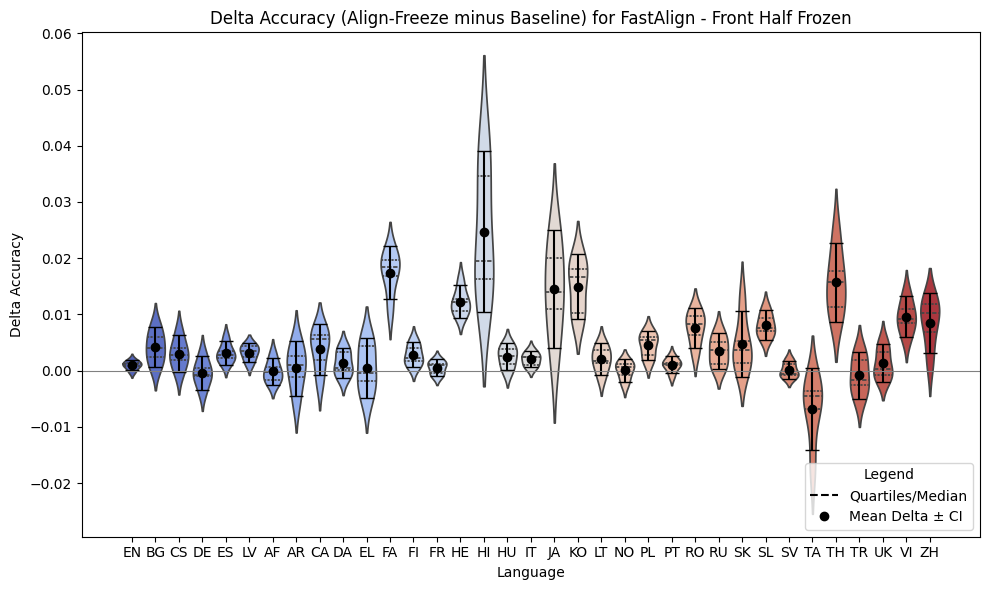

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


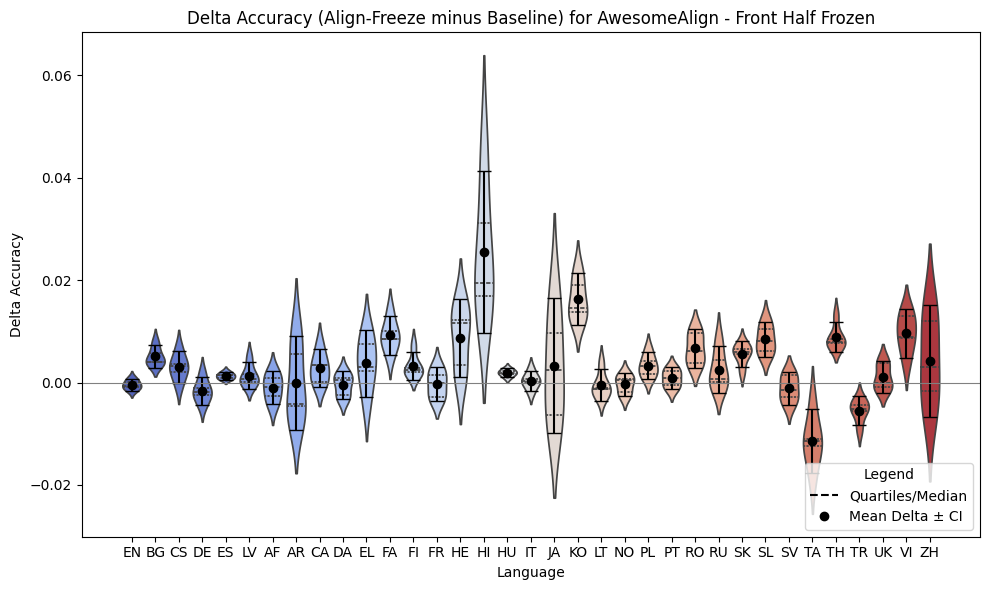

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


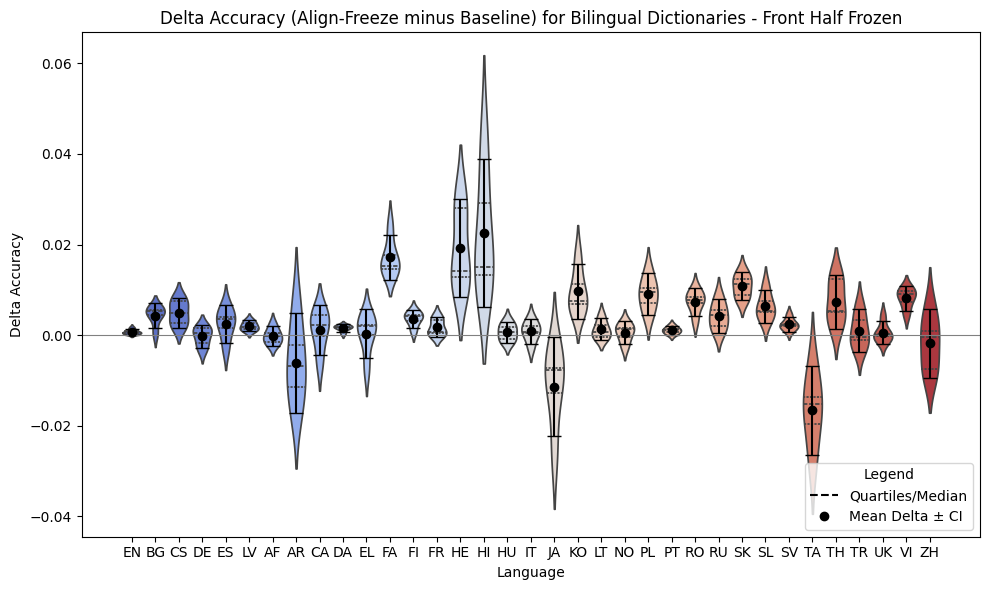

In [7]:
project_pairs = [
    ("3nl_34langs_before_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_34langs_before_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_34langs_before_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_dico_udpos"),
]

plot_individual_violin_deltas_with_cis(project_pairs, langs)

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


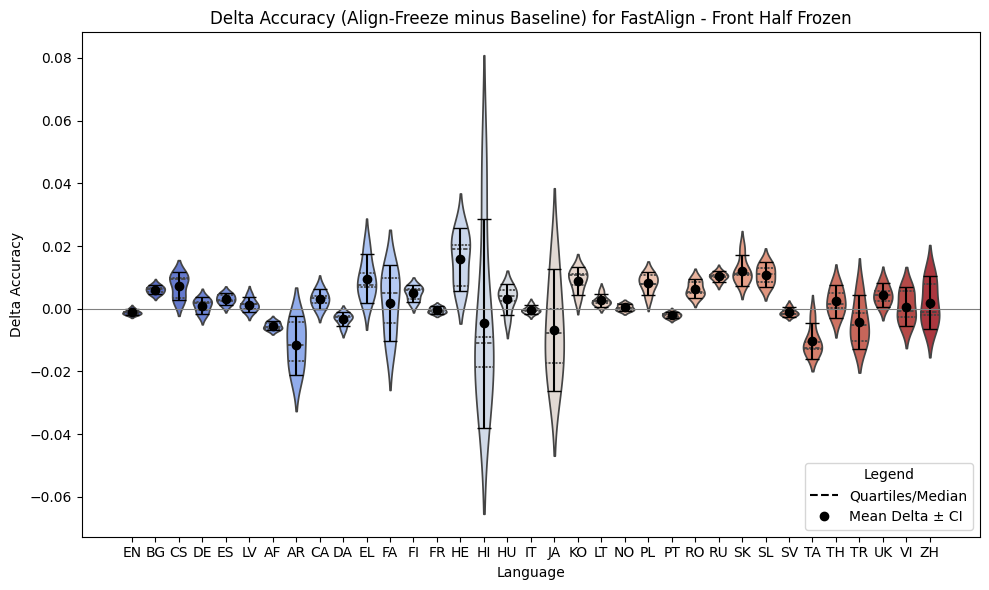

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


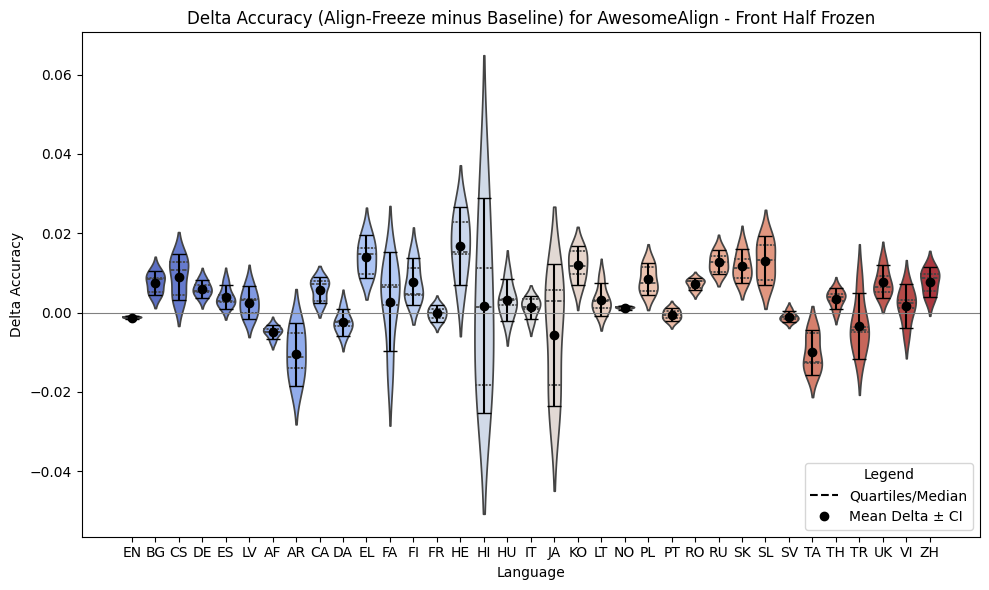

/tmp/ipykernel_1304512/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


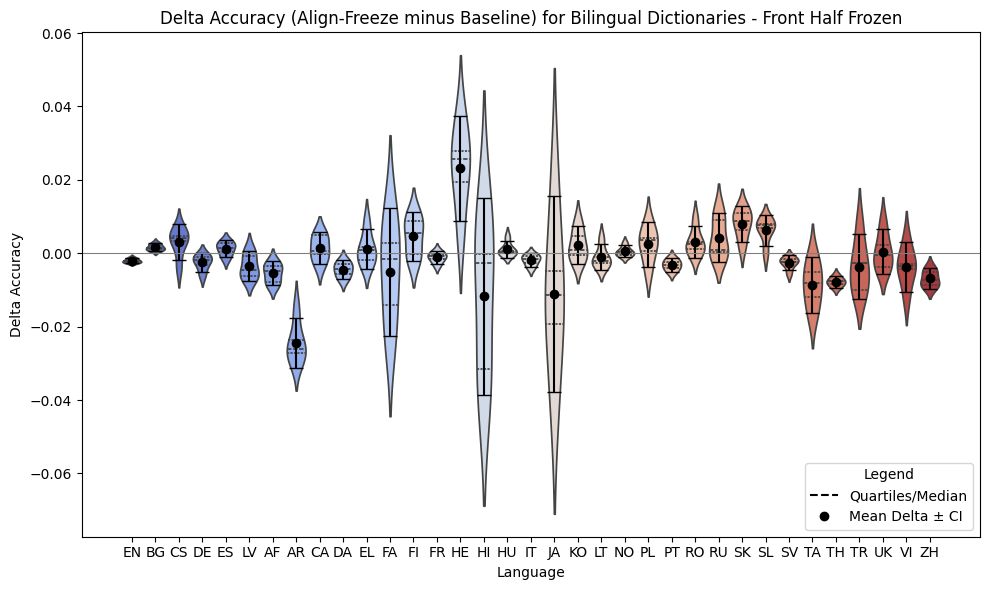

In [8]:
project_pairs = [
    ("3nl_34langs_during_fastalign_udpos", "3nl_34langs_during_partial_freeze_front_fastalign_udpos"),
    ("3nl_34langs_during_awesome_udpos", "3nl_34langs_during_partial_freeze_front_awesome_udpos"),
    ("3nl_34langs_during_dico_udpos", "3nl_34langs_during_partial_freeze_front_dico_udpos"),
]

plot_individual_violin_deltas_with_cis(project_pairs, langs)

In [9]:
# General function to create violin plots for deltas with confidence intervals, grouped by a specified classification
def plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triples, langs, grouping, group_name):
    titles = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']

    group_to_nb = defaultdict(int)
    for group in grouping.values():
        group_to_nb[group] += 1

    for project_idx, (baseline_project, front_half_frozen_project, back_half_frozen_project) in enumerate(project_triples):
        all_delta_data = []
        baseline_data = fetch_and_process_runs(baseline_project)
        front_half_frozen_data = fetch_and_process_runs(front_half_frozen_project)
        back_half_frozen_data = fetch_and_process_runs(back_half_frozen_project)

        for lang in langs:
            front_deltas = [front - baseline for baseline, front in zip(baseline_data[lang], front_half_frozen_data[lang])]
            back_deltas = [back - baseline for baseline, back in zip(baseline_data[lang], back_half_frozen_data[lang])]
            group = grouping.get(lang, 'Other')
            all_delta_data.extend([{'Group': f'{group} ({group_to_nb[group]})', 'Delta': delta, 'Type': 'Front Half Frozen'} for delta in front_deltas])
            all_delta_data.extend([{'Group': f'{group} ({group_to_nb[group]})', 'Delta': delta, 'Type': 'Back Half Frozen'} for delta in back_deltas])

        df = pd.DataFrame(all_delta_data)
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Group', y='Delta', hue='Type', data=df, split=True, inner='quartile', palette='coolwarm', width=1.2)

        plt.title(f'Delta Accuracy Comparison by {group_name} - {titles[project_idx]}')
        plt.axhline(0, color='grey', linewidth=0.8)
        plt.ylabel('Delta Accuracy')
        ax.legend(title="Frozen Half")

        unique_groups = df['Group'].unique()
        group_positions = ax.get_xticks()
        hue_order = ['Front Half Frozen', 'Back Half Frozen']
        # Reduced offset for closer horizontal positioning
        offset = 0.05  # Adjust this value to move error bars closer within each violin section

        for i, group in enumerate(unique_groups):
            group_pos = group_positions[i]
            for j, type_label in enumerate(hue_order):
                subset = df[(df['Group'] == group) & (df['Type'] == type_label)]
                mean = subset['Delta'].mean()
                ci = scipy.stats.sem(subset['Delta']) * scipy.stats.t.ppf((1 + 0.95) / 2., len(subset['Delta'])-1)
                # Adjusted horizontal position
                position = group_pos - offset if type_label == 'Front Half Frozen' else group_pos + offset
                plt.errorbar(position, mean, yerr=ci, fmt='o', color='black', capsize=5, capthick=2)

        plt.tight_layout()
        plt.show()

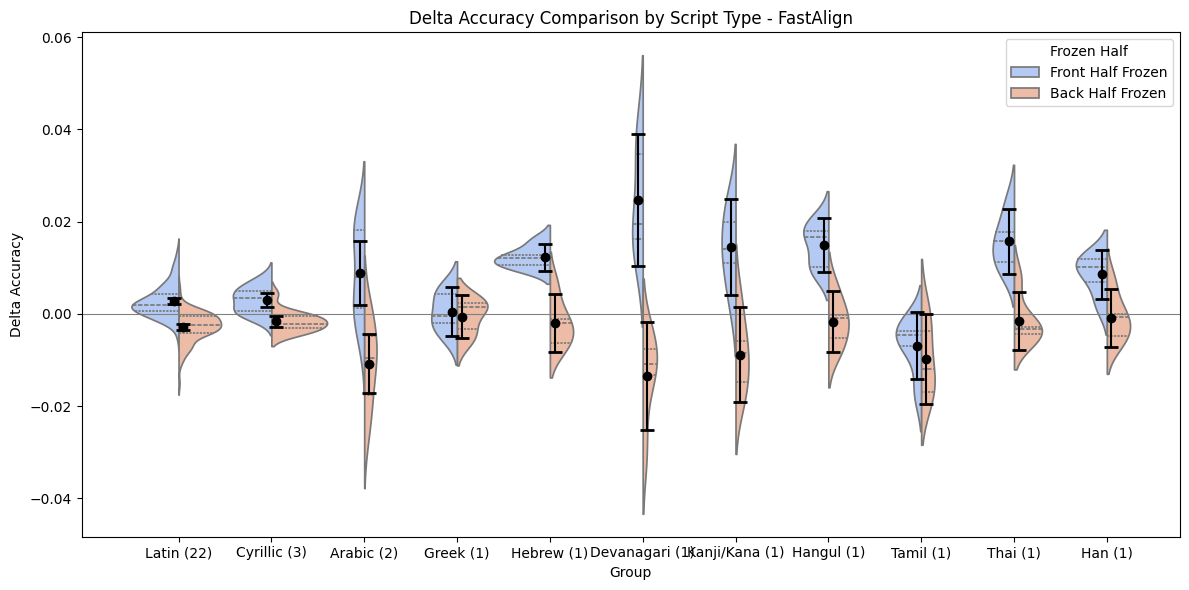

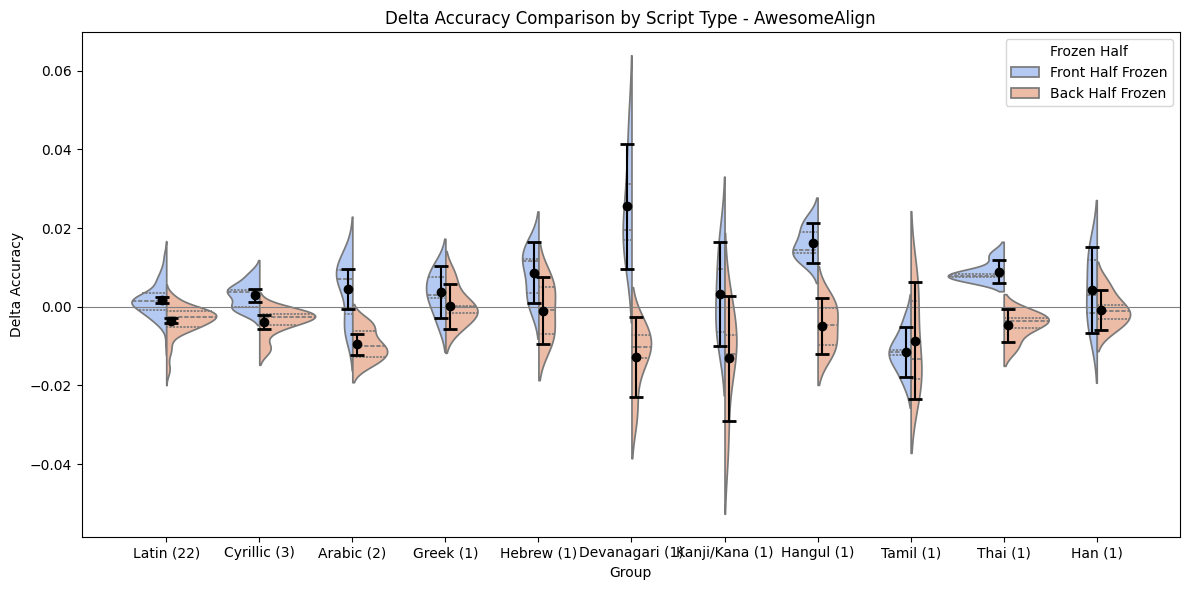

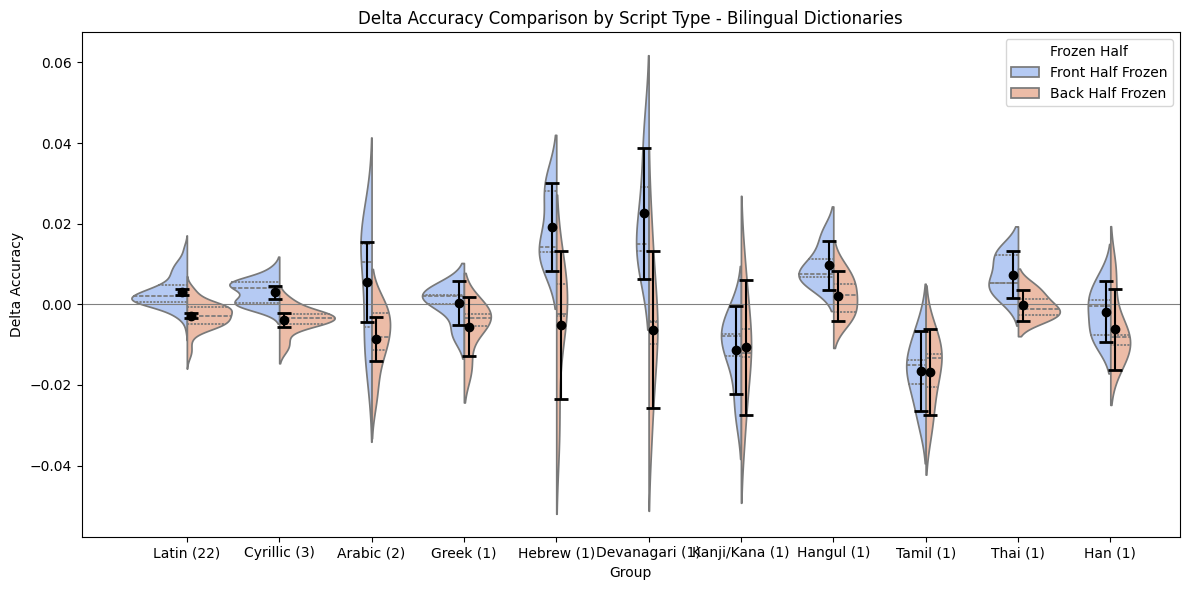

In [10]:
# Checking the before method
project_triple = [
    ("3nl_34langs_before_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos"),
    ("3nl_34langs_before_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos"),
    ("3nl_34langs_before_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos"),
]

# Define the script type mapping
grouping = {
    'same': 'Latin',  
    'ar': 'Arabic',
    'es': 'Latin',
    'fr': 'Latin',
    'ru': 'Cyrillic',
    'zh': 'Han',
    'af': 'Latin',
    'fa': 'Arabic',
    'hi': 'Devanagari',
    'bg': 'Cyrillic',
    "cs": 'Latin',
    'de': 'Latin',
    'es': 'Latin',
    'lv': 'Latin',
    'ca': 'Latin',
    'da': 'Latin',
    'el': 'Greek',
    'fi': 'Latin',
    'he': 'Hebrew',
    'hu': 'Latin',
    'it': 'Latin',
    'ja': 'Kanji/Kana',
    'ko': 'Hangul',
    'lt': 'Latin',
    'no': 'Latin',
    'pl': 'Latin',
    'pt': 'Latin',
    'ro': 'Latin',
    'sk': 'Latin',
    'sl': 'Latin',
    'sv': 'Latin',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Latin',
    'uk': 'Cyrillic',
    'vi': 'Latin'
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Script Type')

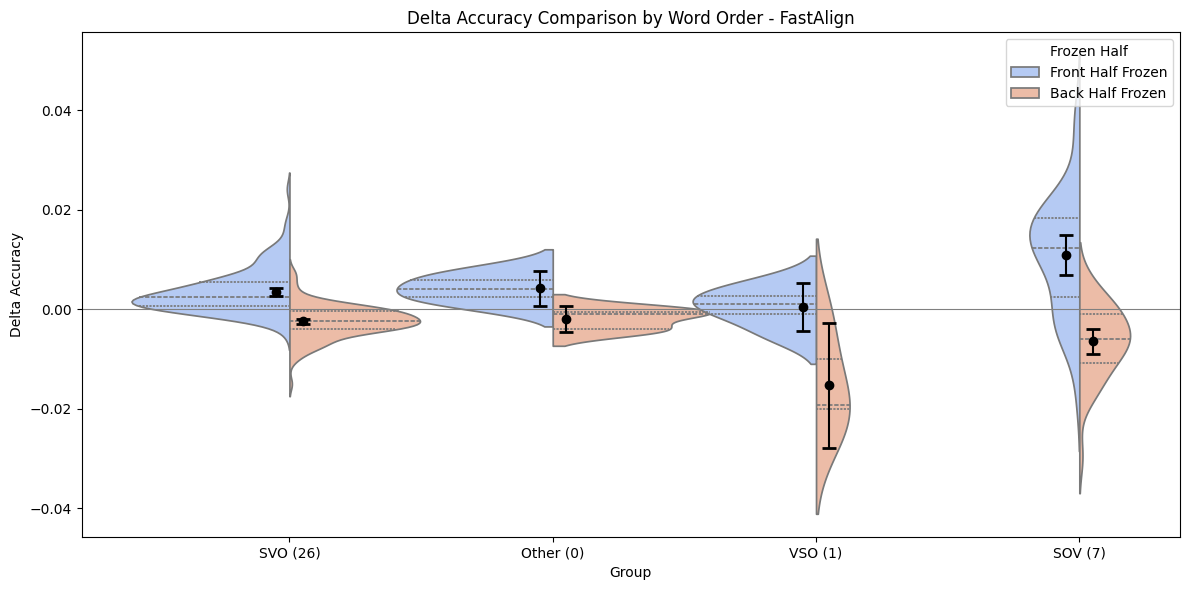

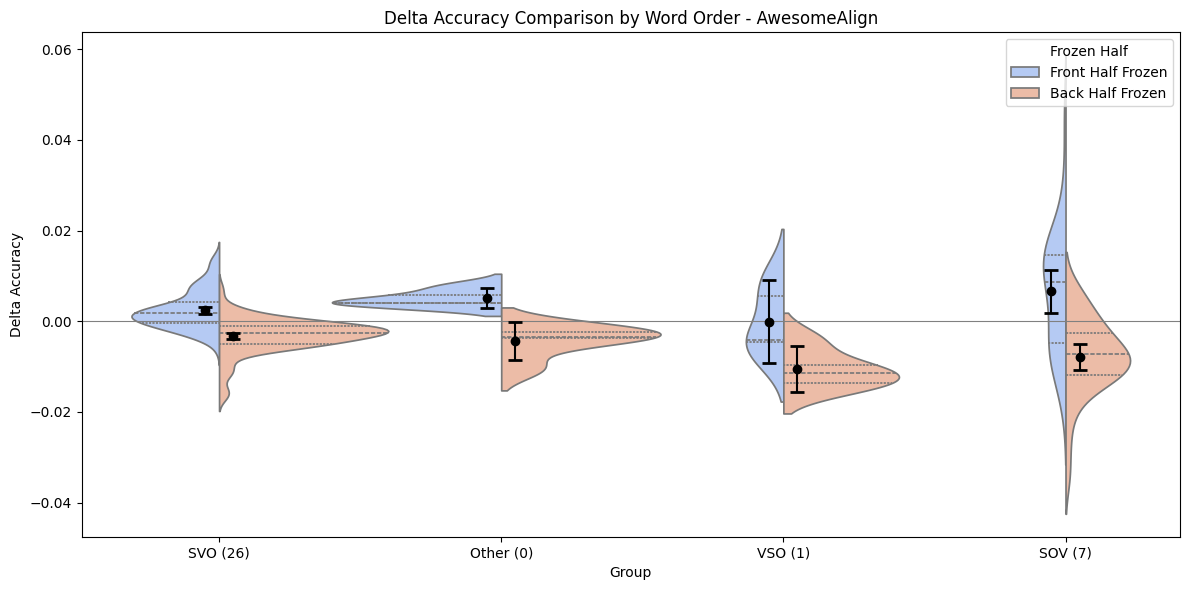

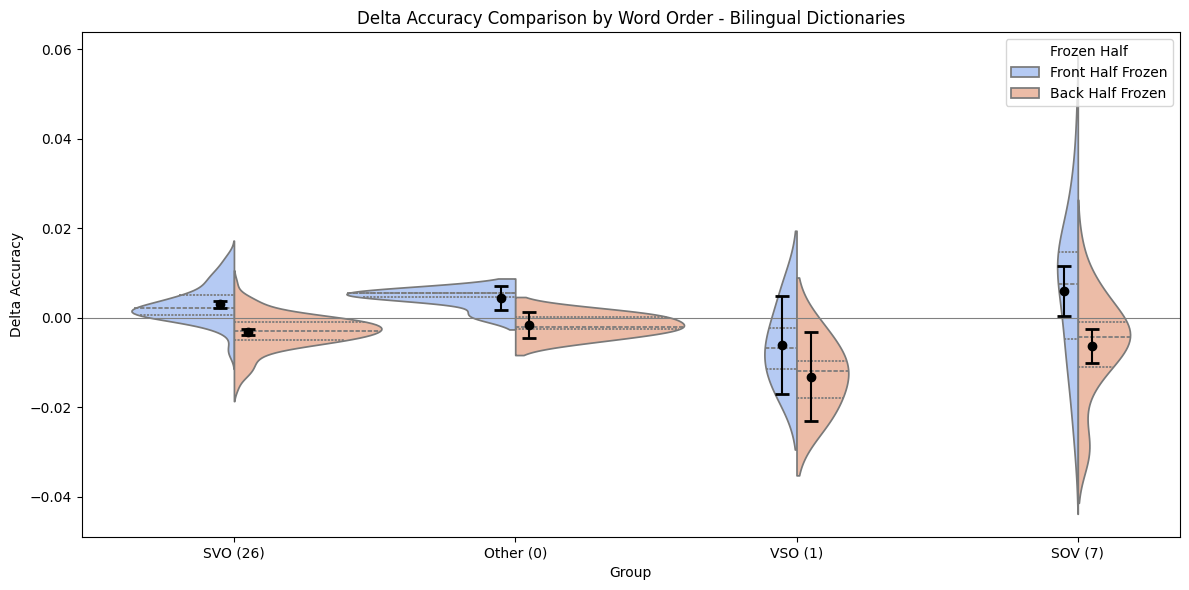

In [11]:
grouping = {
    'same': 'SVO',  # English
    'ar': 'VSO',  # Arabic
    'es': 'SVO',  # Spanish
    'fr': 'SVO',  # French
    'ru': 'SVO',  # Russian
    'zh': 'SVO',  # Chinese
    'af': 'SVO',  # Afrikaans
    'fa': 'SOV',  # Persian
    'hi': 'SOV',   # Hindi
    # bg: removed because seems to be very free
    "cs": 'SVO', # Although it remains relatively free (case system)
    'de': 'SVO',
    'es': 'SVO',
    'lv': 'SVO',
    'ca': 'SVO',
    'da': 'SVO',
    'el': 'SVO', # But can vary a lot
    'fi': 'SVO',
    'he': 'SOV', # But biblical Hebrew is VSO
    'hu': 'SVO',
    'it': 'SVO',
    'ja': 'SOV',
    'ko': 'SOV',
    'lt': 'SVO',
    'no': 'SVO',
    'pl': 'SVO',
    'pt': 'SVO',
    'ro': 'SVO',
    'sk': 'SVO', # but relatively free
    'sl': 'SVO',
    'sv': 'SVO',
    'ta': 'SOV',
    'th': 'SVO',
    'tr': 'SOV',
    'uk': 'SVO',
    'vi': 'SVO'
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Word Order')


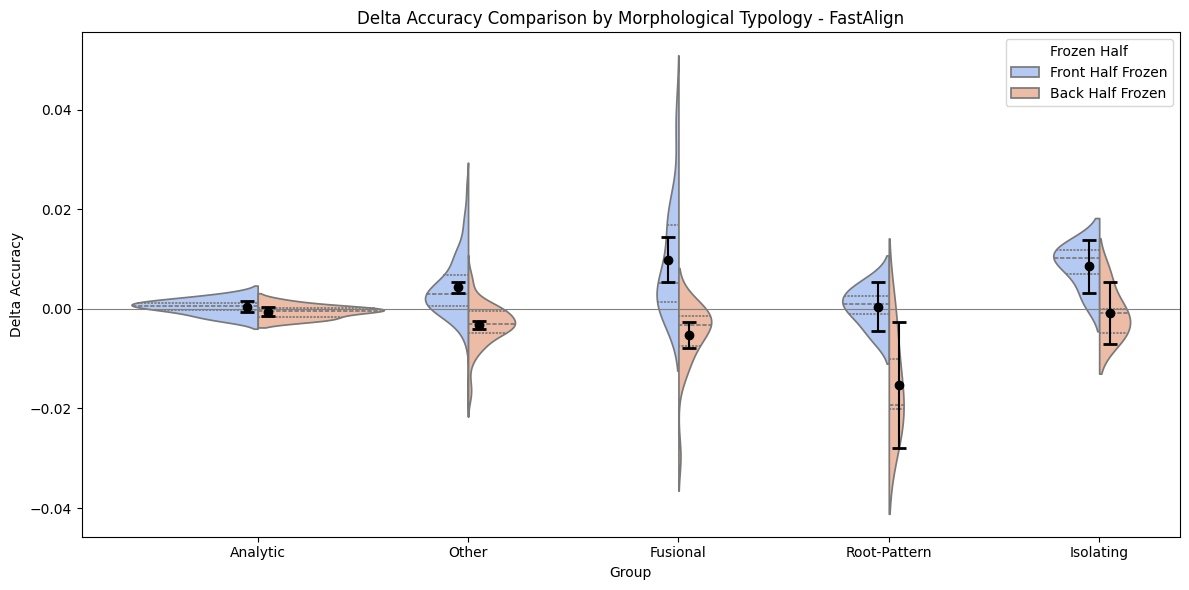

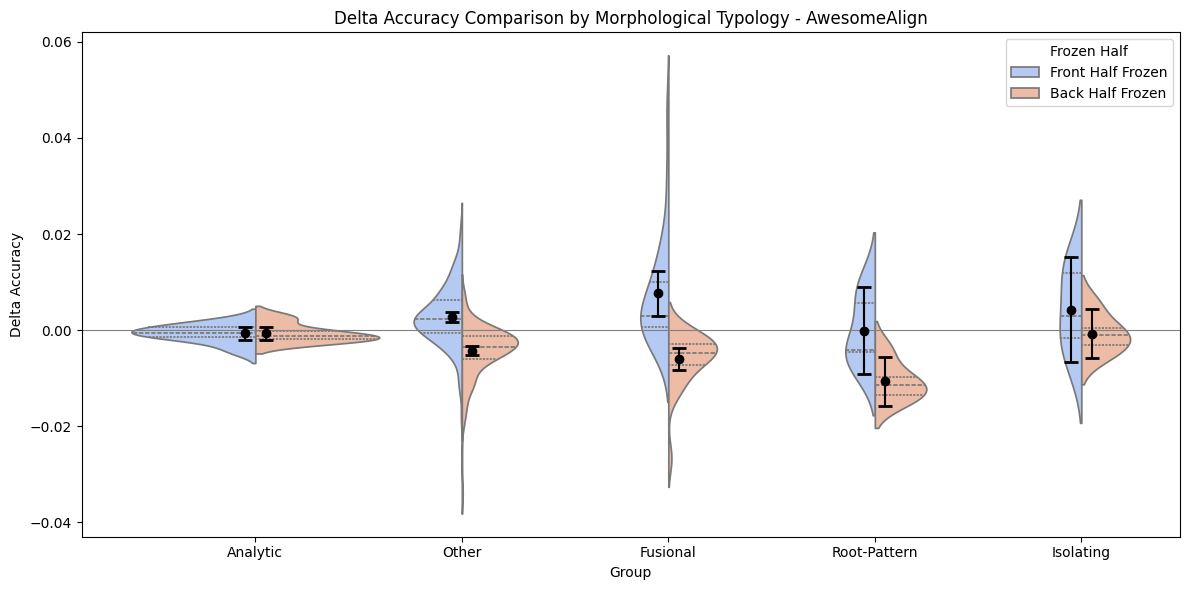

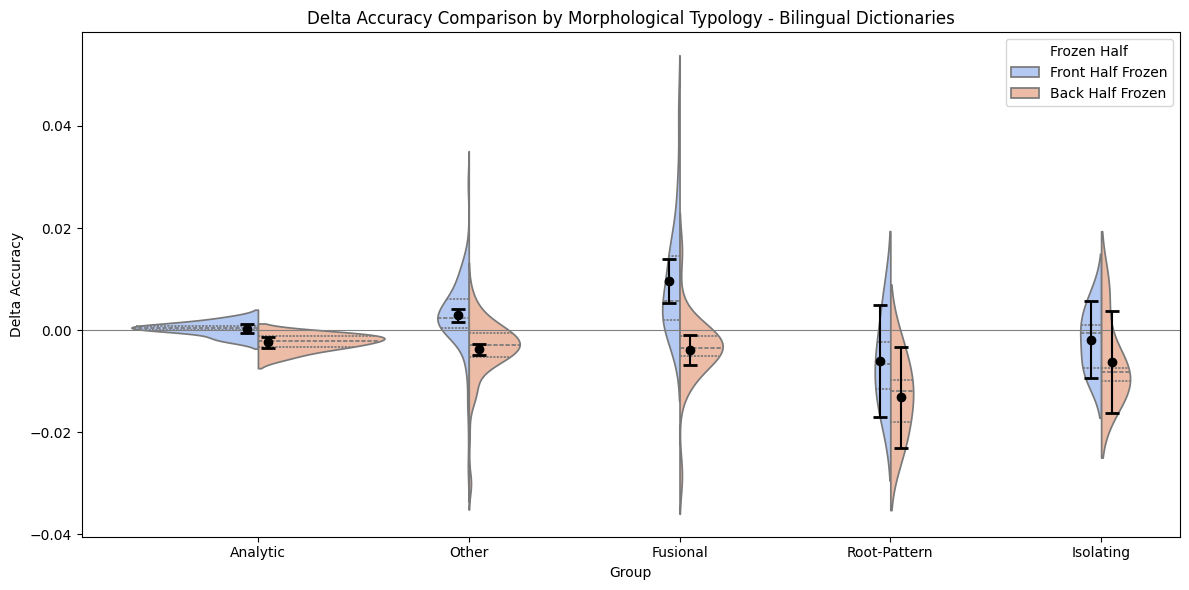

In [10]:
grouping = {
    'same': 'Analytic',   # English, as it relies more on word order and prepositions than on inflectional morphology [(Pirkola, 2001)](https://consensus.app/papers/morphological-typology-languages-pirkola/05f681f661f45eddaf9d221c41197a8b/?utm_source=chatgpt).
    'ar': 'Root-Pattern', # Arabic, known for its root-pattern morphology typical of Semitic languages [(Alduais, 2018)](https://consensus.app/papers/overview-typology-morphological-features-arabic-alduais/7fe3229157915d3e90d19f93676f4b99/?utm_source=chatgpt).
    'es': 'Fusional',     # Spanish is highly inflected for tense, case, and gender, similar to other Romance languages [(Gispert & Mariño, 2008)](https://consensus.app/papers/impact-morphology-english-spanish-gispert/bff5eeff814c51b199973f4abd34b5e5/?utm_source=chatgpt).
    'fr': 'Fusional',     # French, similar to Spanish in inflectional complexity.
    'ru': 'Fusional',     # Russian, a highly inflected language with complex system of declensions and verb conjugations [(Kalikova et al., 2023)](https://consensus.app/papers/differences-models-kalikova/3b8e216089c458c8afbc2b01bfb56152/?utm_source=chatgpt).
    'zh': 'Isolating',    # Chinese, relying heavily on word order and context rather than inflectional changes.
    'af': 'Analytic',     # Afrikaans, similar to English, with significant reduction in inflectional morphology compared to Dutch.
    'fa': 'Fusional',     # Persian, has moderate inflectional morphology but less complex compared to ancient Indo-Iranian languages.
    'hi': 'Fusional'      # Hindi, features significant amount of inflectional morphology typical of Indo-Aryan languages [(Goyal & Lehal, 2008)](https://consensus.app/papers/hindi-morphological-analyzer-generator-goyal/e7bd7d43811b5cd4bed5fa1c20092062/?utm_source=chatgpt).
    # bg: removed because seems to be very free
    # "cs": ,
    # 'de': ,
    # 'es': ,
    # 'lv': ,
    # 'ca': ,
    # 'da': ,
    # 'el': ,
    # 'fi': ,
    # 'he': ,
    # 'hu': ,
    # 'it': ,
    # 'ja': ,
    # 'ko': ,
    # 'lt': ,
    # 'no': ,
    # 'pl': ,
    # 'pt': ,
    # 'ro': ,
    # 'sk': ,
    # 'sl': ,
    # 'sv': ,
    # 'ta': ,
    # 'th': ,
    # 'tr': ,
    # 'uk': ,
    # 'vi': 
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Morphological Typology')

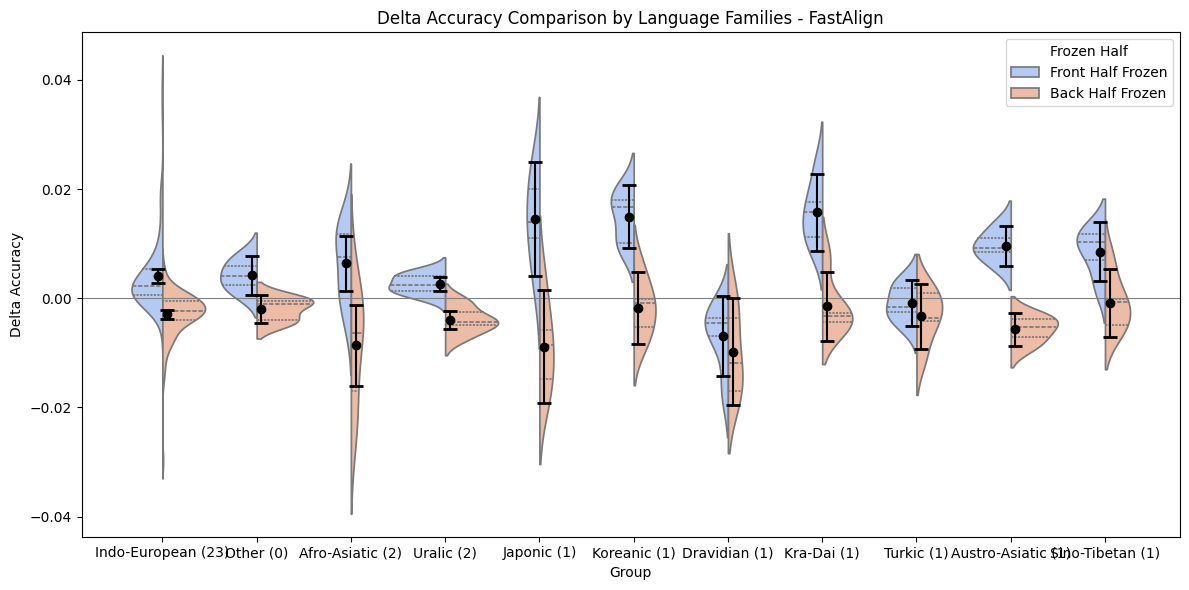

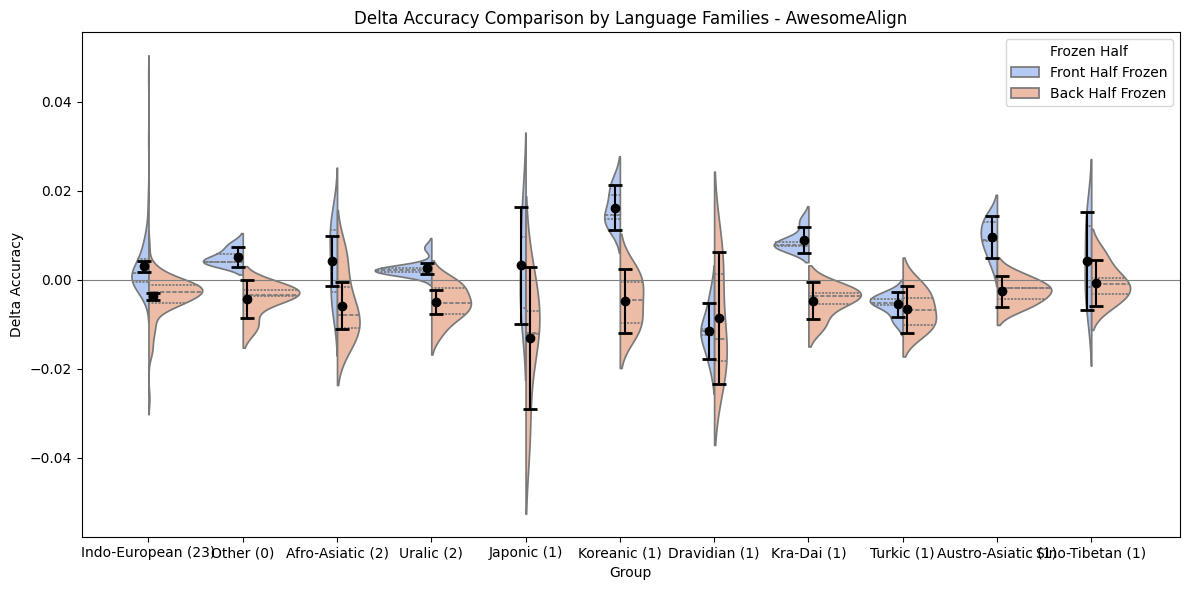

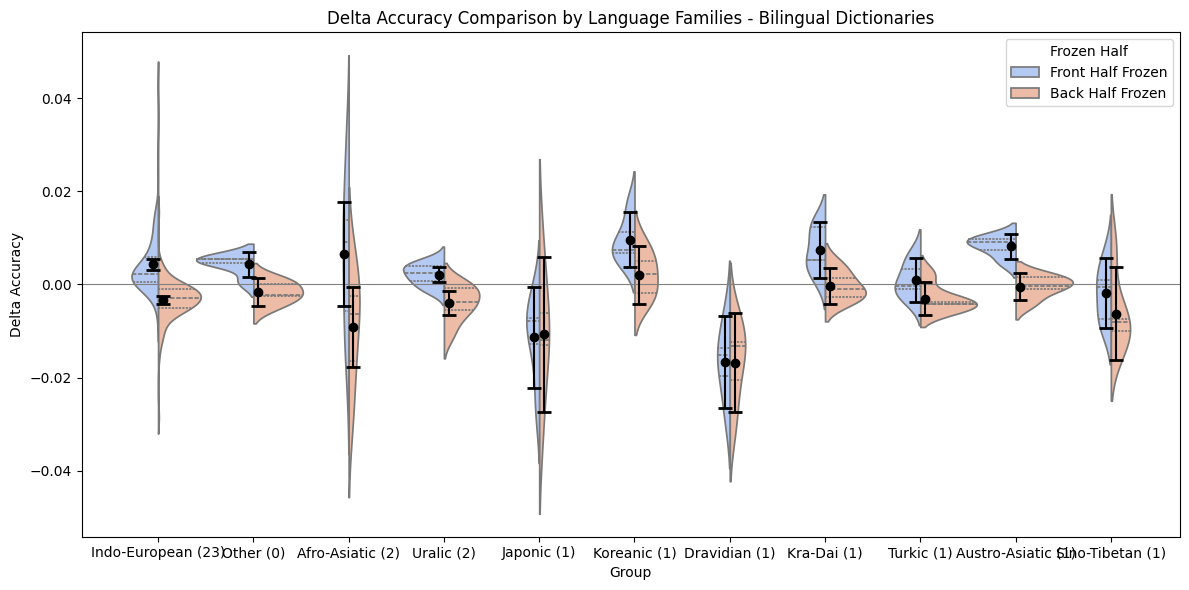

In [12]:
grouping = {
    'same': 'Indo-European',  # English
    'ar': 'Afro-Asiatic',   # Arabic
    'es': 'Indo-European',  # Spanish
    'fr': 'Indo-European',  # French
    'ru': 'Indo-European',  # Russian
    'zh': 'Sino-Tibetan',   # Chinese
    'af': 'Indo-European',  # Afrikaans
    'fa': 'Indo-European',  # Persian
    'hi': 'Indo-European',   # Hindi
    "cs": 'Indo-European',
    'de': 'Indo-European',
    'es': 'Indo-European',
    'lv': 'Indo-European',
    'ca': 'Indo-European',
    'da': 'Indo-European',
    'el': 'Indo-European',
    'fi': 'Uralic',
    'he': 'Afro-Asiatic',
    'hu': 'Uralic',
    'it': 'Indo-European',
    'ja': 'Japonic',
    'ko': 'Koreanic',
    'lt': 'Indo-European',
    'no': 'Indo-European',
    'pl': 'Indo-European',
    'pt': 'Indo-European',
    'ro': 'Indo-European',
    'sk': 'Indo-European',
    'sl': 'Indo-European',
    'sv': 'Indo-European',
    'ta': 'Dravidian',
    'th': 'Kra-Dai',
    'tr': 'Turkic',
    'uk': 'Indo-European',
    'vi': 'Austro-Asiatic'
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Language Families')

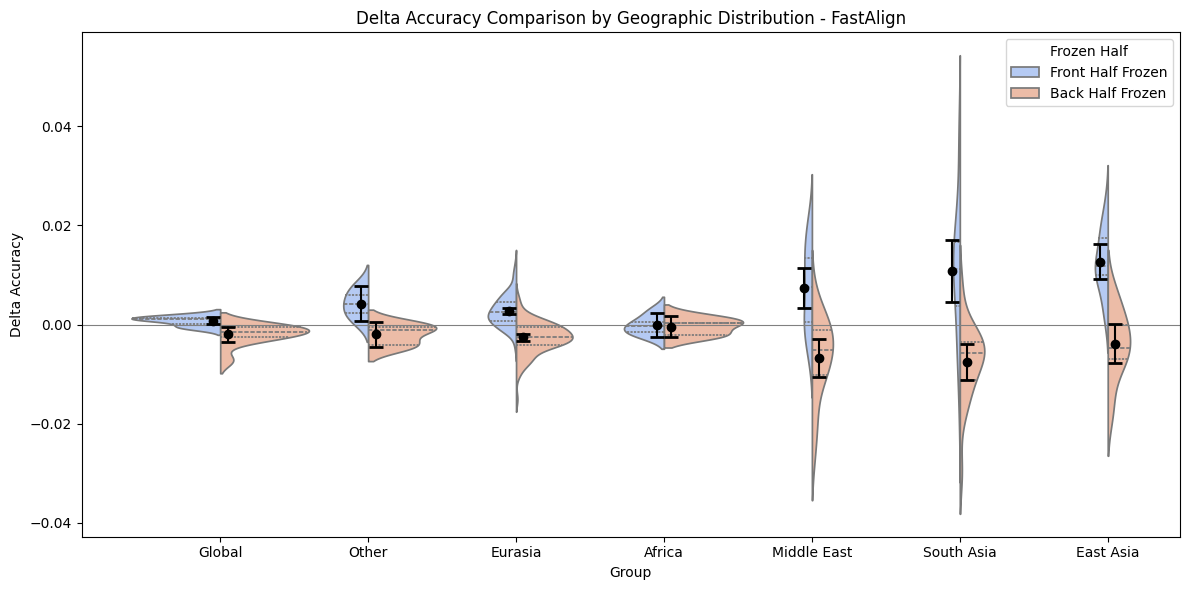

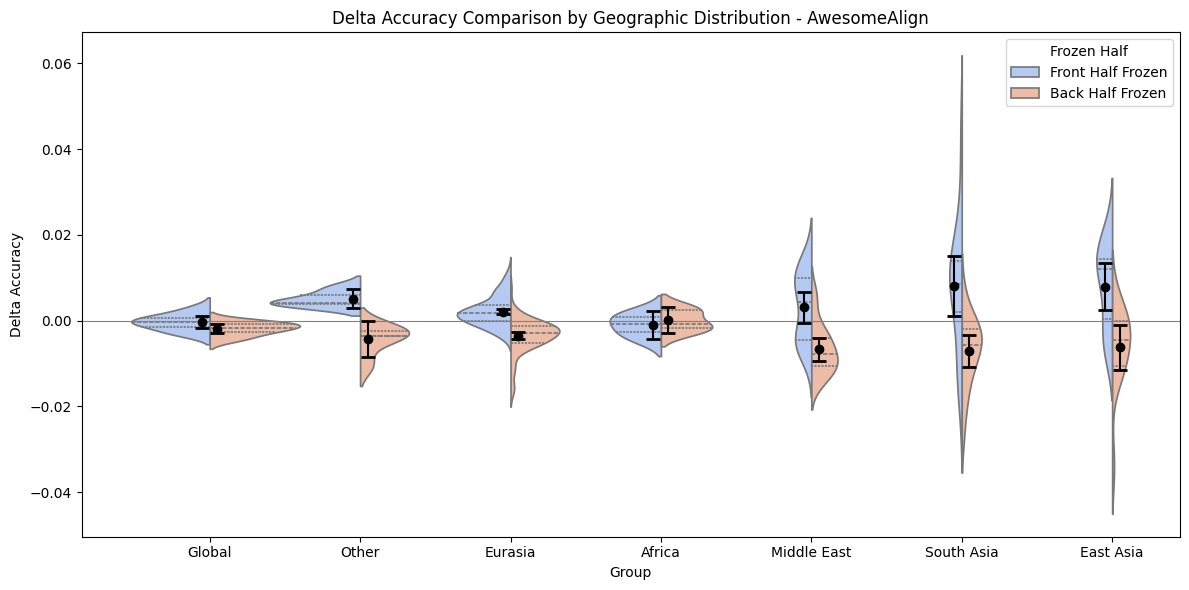

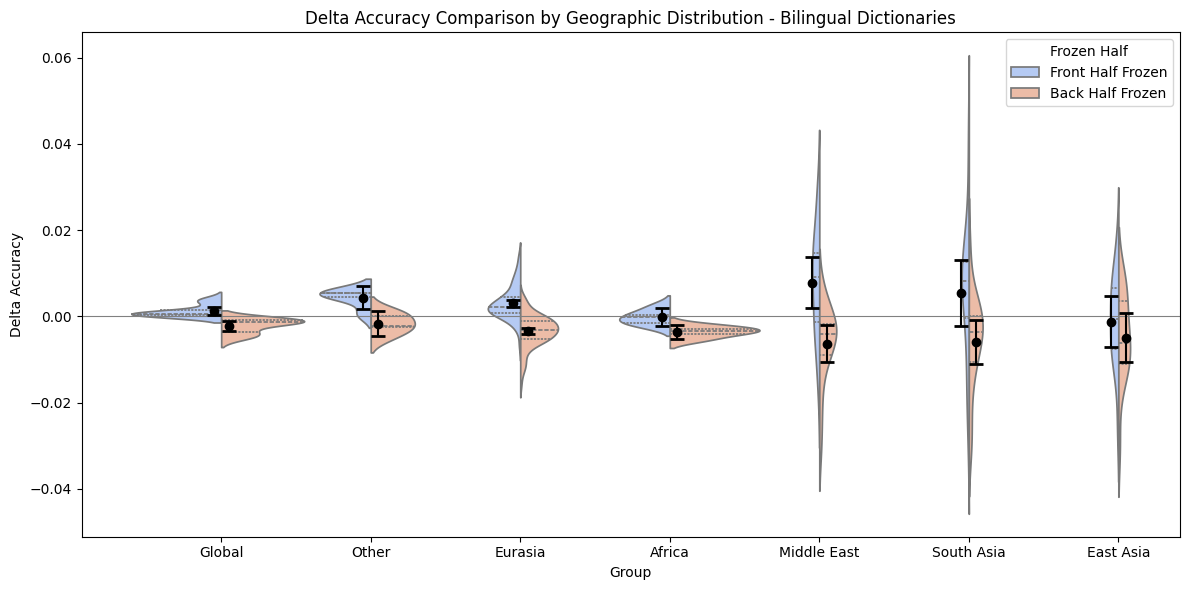

In [14]:
grouping = {
    'same': 'Global',    # English
    'ar': 'Middle East',  # Arabic
    'es': 'Global',    # Spanish
    'fr': 'Global',    # French
    'ru': 'Eurasia',   # Russian
    'zh': 'East Asia', # Chinese
    'af': 'Africa',    # Afrikaans
    'fa': 'Middle East',  # Persian
    'hi': 'South Asia',  # Hindi
    "cs": 'Eurasia',
    'de': 'Eurasia',
    'es': 'Eurasia',
    'lv': 'Eurasia',
    'ca': 'Eurasia',
    'da': 'Eurasia',
    'el': 'Eurasia',
    'fi': 'Eurasia',
    'he': 'Middle East',
    'hu': 'Eurasia',
    'it': 'Eurasia',
    'ja': 'East Asia',
    'ko': 'East Asia',
    'lt': 'Eurasia',
    'no': 'Eurasia',
    'pl': 'Eurasia',
    'pt': 'Eurasia',
    'ro': 'Eurasia',
    'sk': 'Eurasia',
    'sl': 'Eurasia',
    'sv': 'Eurasia',
    'ta': 'South Asia',
    'th': 'South Asia',
    'tr': 'Middle East',
    'uk': 'Eurasia',
    'vi': 'South Asia'
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Geographic Distribution')

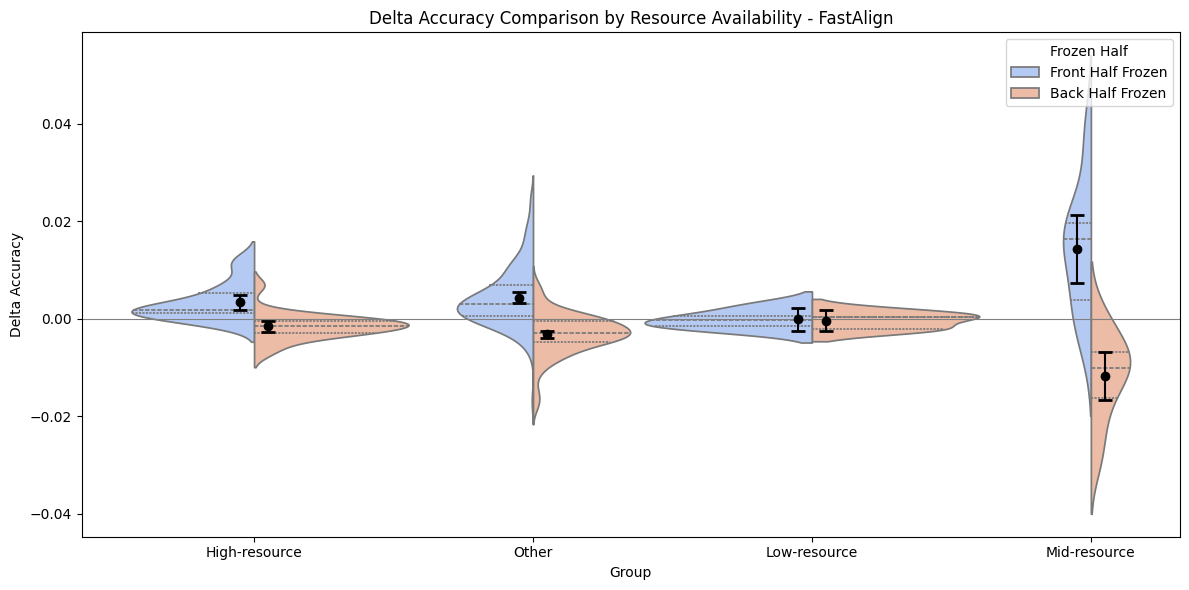

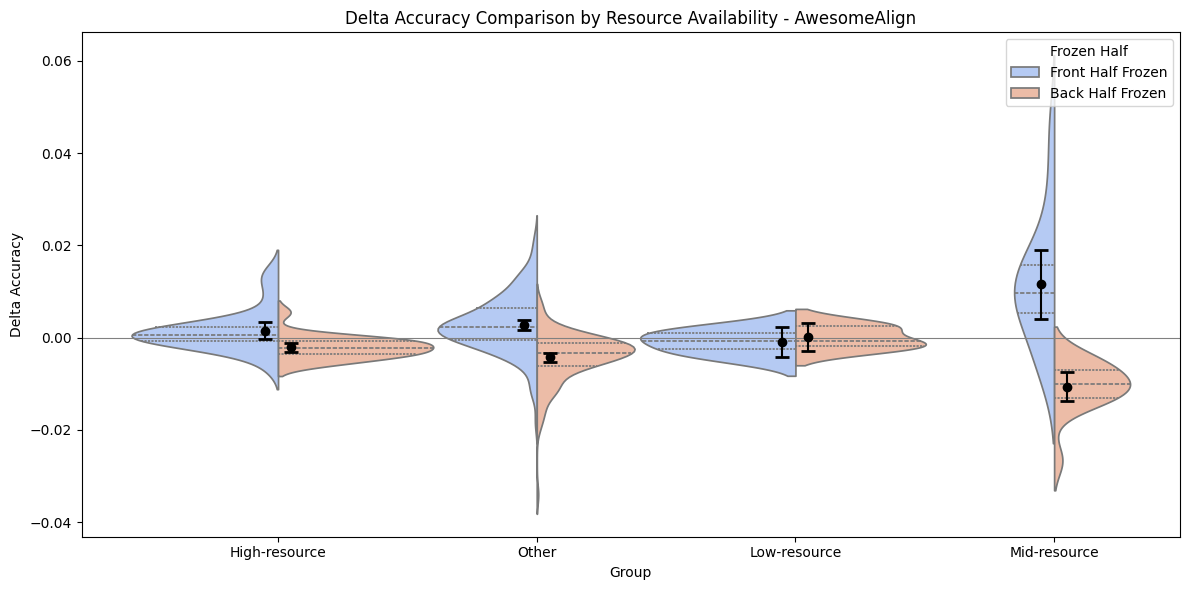

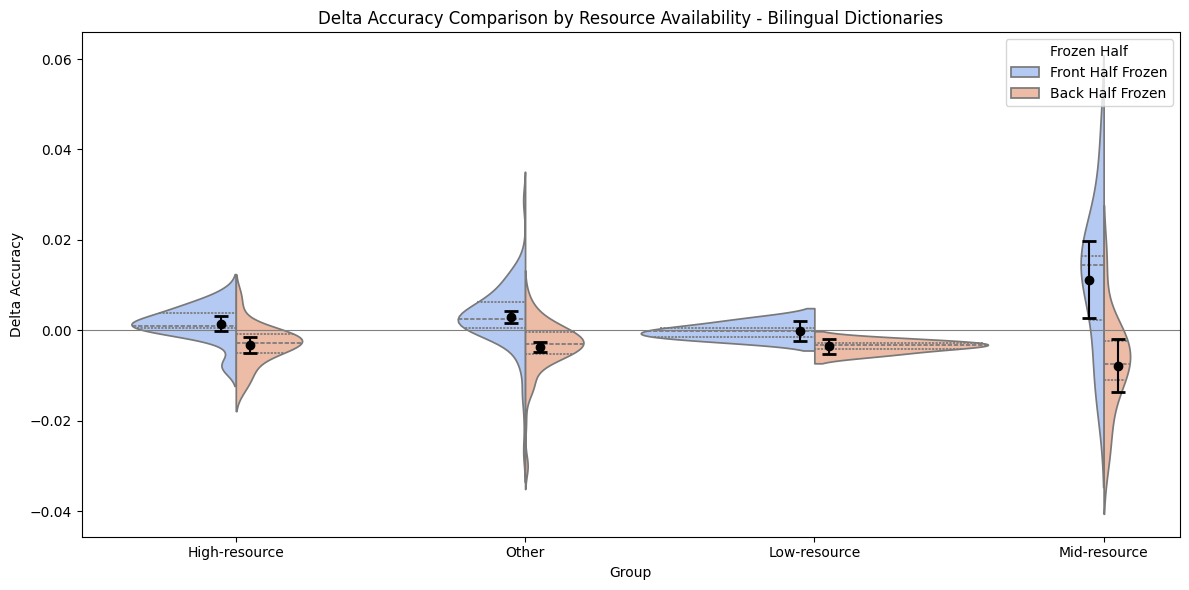

In [40]:
grouping = {
    'same': 'High-resource',    # English
    'ar': 'Mid-resource',     # Arabic
    'es': 'High-resource',    # Spanish
    'fr': 'High-resource',    # French
    'ru': 'High-resource',    # Russian
    'zh': 'High-resource',    # Chinese
    'af': 'Low-resource',     # Afrikaans
    'fa': 'Mid-resource',     # Persian
    'hi': 'Mid-resource'      # Hindi
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Resource Availability')